### Initialize

In [1]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [2]:
import torch
from networks import MLP
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
load_dir = '../output/no_offset_ddpg_0/'
obs_size = 8
action_size = 2

In [4]:
device = torch.device(0)
device

device(type='cuda', index=0)

In [5]:
torch.manual_seed(3)

### Get experience buffer

In [6]:
exp_buffer = torch.load('../output/no_offset_ddpg_0/exp_buffer.pt')
# entries are (s, a, r, s', done_flag) with |s|=8, |a|=2, |r|=1, |done_flag|=1

In [7]:
exp_buffer = torch.load(os.path.join(load_dir, "exp_buffer.pt"))
with open(os.path.join(load_dir, "exp_buffer_state.json"), "r") as fp:
    exp_buffer_state = json.load(fp)
    next_ind = exp_buffer_state["next_ind"]
    full = exp_buffer_state["full"]

In [8]:
exp_buffer

tensor([[0.0050, 1.4019, 0.5016,  ..., 0.0000, 0.0000, 0.0000],
        [0.0099, 1.3923, 0.5010,  ..., 0.0000, 0.0000, 0.0000],
        [0.0149, 1.3821, 0.5010,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [9]:
# trim empty entries
exp_buffer = exp_buffer[:next_ind]
# randomly shuffle
exp_buffer = exp_buffer[torch.randperm(exp_buffer.size()[0])]

In [10]:
exp_buffer

tensor([[-0.6444,  1.1945, -0.1584,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4989,  1.2683, -0.9839,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0245,  1.4435, -0.4111,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0294,  1.3901, -0.0742,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4004,  0.7039,  0.5399,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1228,  1.4291,  0.1405,  ...,  0.0000,  0.0000,  0.0000]])

### Make dataset by hallucinating offsets

In [11]:
num_samples = exp_buffer.size()[0]
num_samples

87085

In [12]:
state, action, reward, next_state, done_mask = torch.split(
    exp_buffer, [obs_size, action_size, 1, obs_size, 1],
    dim=1
)

In [13]:
offsets = torch.rand((num_samples,action_size)) - 0.5
print(torch.min(offsets), torch.max(offsets))
action.size(), offsets.size()

tensor(-0.5000) tensor(0.5000)


(torch.Size([87085, 2]), torch.Size([87085, 2]))

In [14]:
hallucinated_actions = action - offsets
Y = offsets

In [15]:
hallucinated_buffer = torch.cat([state, hallucinated_actions, reward, next_state, done_mask], dim=1)
X = hallucinated_buffer

In [16]:
X.size(), Y.size()

(torch.Size([87085, 20]), torch.Size([87085, 2]))

### Make dataset splits

In [17]:
val_frac = 0.1
test_frac = 0.1
num_val = round(num_samples * val_frac)
num_test = round(num_samples * test_frac)
num_train = num_samples - num_val - num_test

X_train, X_val, X_test = torch.split(X, [num_train, num_val, num_test], dim=0)
Y_train, Y_val, Y_test = torch.split(Y, [num_train, num_val, num_test], dim=0)

In [18]:
print(X_train.size(), X_val.size(), X_test.size())
print(Y_train.size(), Y_val.size(), Y_test.size())

torch.Size([69669, 20]) torch.Size([8708, 20]) torch.Size([8708, 20])
torch.Size([69669, 2]) torch.Size([8708, 2]) torch.Size([8708, 2])


In [19]:
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

In [20]:
batch_size = 32
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                        shuffle=False, num_workers=num_workers)

### Train MLP

In [103]:
# model = MLP([20,64,32,2]).to(device)
model = MLP([20,256,128,64,2]).to(device)
# model = MLP([20,256,128,64,2], lambda x: 0.5 * torch.tanh(x)).to(device)

In [104]:
epochs = 10000
learning_rate = 1e-6
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
best_val_output_path = 'output/sas_to_offset_MLP_1_bestval.pt'

In [105]:
best_val_loss = float('inf')

for epoch in range(epochs):  # loop over the dataset multiple times
    # print(f"epoch {epoch}")

    running_train_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...
            # print(f'iter {i+1:6}  train loss: {running_train_loss/1000}')
            running_train_loss = 0.0
    
    with torch.no_grad():
        running_val_loss = 0
        num_val_batches = 0
        for i, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            num_val_batches += 1

        val_loss = running_val_loss / num_val_batches
        # print(f"epoch {epoch} val MSE loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            print(f"epoch {epoch} val RMSE loss: {np.sqrt(val_loss):.6f} *")
            torch.save(model, best_val_output_path)
            best_val_loss = val_loss
        else:
            print(f"epoch {epoch} val RMSE loss: {np.sqrt(val_loss):.6f}")


epoch 0 val RMSE loss: 0.231688 *
epoch 1 val RMSE loss: 0.212234 *
epoch 2 val RMSE loss: 0.205635 *
epoch 3 val RMSE loss: 0.202520 *
epoch 4 val RMSE loss: 0.200437 *
epoch 5 val RMSE loss: 0.199093 *
epoch 6 val RMSE loss: 0.197569 *
epoch 7 val RMSE loss: 0.195987 *
epoch 8 val RMSE loss: 0.194008 *
epoch 9 val RMSE loss: 0.193533 *
epoch 10 val RMSE loss: 0.192826 *
epoch 11 val RMSE loss: 0.193011
epoch 12 val RMSE loss: 0.191495 *
epoch 13 val RMSE loss: 0.190047 *
epoch 14 val RMSE loss: 0.188851 *
epoch 15 val RMSE loss: 0.188864
epoch 16 val RMSE loss: 0.187272 *
epoch 17 val RMSE loss: 0.188637
epoch 18 val RMSE loss: 0.186078 *
epoch 19 val RMSE loss: 0.187983
epoch 20 val RMSE loss: 0.184805 *
epoch 21 val RMSE loss: 0.184740 *
epoch 22 val RMSE loss: 0.185490
epoch 23 val RMSE loss: 0.182766 *
epoch 24 val RMSE loss: 0.183601
epoch 25 val RMSE loss: 0.182418 *
epoch 26 val RMSE loss: 0.182373 *
epoch 27 val RMSE loss: 0.180856 *
epoch 28 val RMSE loss: 0.180447 *
epoch 2

KeyboardInterrupt: 

In [24]:
# output model
# output_path = 'output/sas_to_offset_MLP_1.pt'
# torch.save(model, output_path)

In [106]:
# loaded_model = torch.load(output_path).to(device)
loaded_model = torch.load('output/sas_to_offset_MLP_1_bestval.pt').to(device)

In [107]:
loaded_model

MLP(
  (net): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [108]:
Y_test[:10]

tensor([[ 0.0105, -0.2003],
        [-0.2153, -0.1874],
        [ 0.4881, -0.1520],
        [ 0.0465, -0.1935],
        [ 0.4636, -0.4498],
        [-0.3340, -0.4061],
        [-0.1094,  0.4550],
        [ 0.0808,  0.1582],
        [ 0.3047,  0.3431],
        [-0.1875, -0.2318]])

In [109]:
loaded_model(X_test[:10].to(device))

tensor([[-0.1251, -0.0779],
        [-0.1284, -0.2043],
        [ 0.3706, -0.1456],
        [ 0.0546, -0.2816],
        [ 0.1520, -0.3331],
        [-0.2705, -0.2731],
        [ 0.0150,  0.4703],
        [ 0.0574,  0.1960],
        [ 0.1905,  0.3226],
        [-0.2216, -0.2743]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [110]:
preds = loaded_model(X_test.to(device))
diffs = Y_test.to(device) - preds
diffs = diffs.detach().cpu()

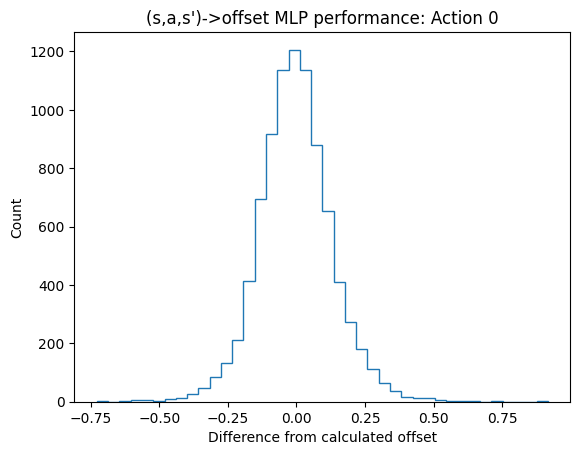

In [111]:
counts, bins = np.histogram(diffs[:,0], bins=40)
plt.stairs(counts, bins)
plt.ylabel('Count')
plt.xlabel('Difference from calculated offset')
plt.title("(s,a,s')->offset MLP performance: Action 0")
plt.show()

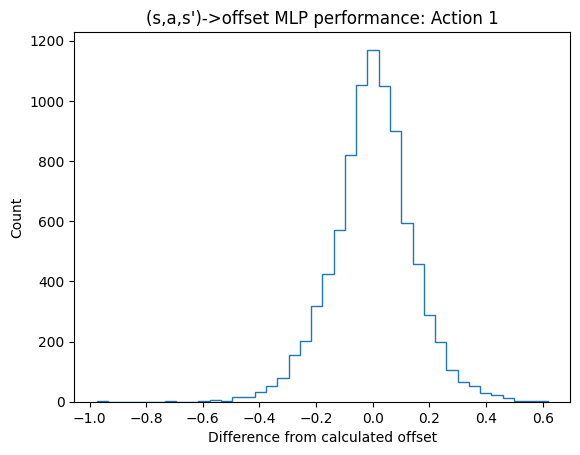

In [112]:
counts, bins = np.histogram(diffs[:,1], bins=40)
plt.stairs(counts, bins)
plt.ylabel('Count')
plt.xlabel('Difference from calculated offset')
plt.title("(s,a,s')->offset MLP performance: Action 1")
plt.show()

### Sanity checks

In [113]:
fake_preds = torch.zeros_like(Y_test)
# fake_preds = torch.rand_like(Y_test) - 0.5
fake_diffs = Y_test - fake_preds

In [114]:
print("Our network's test RMSE", torch.sqrt(torch.nn.functional.mse_loss(preds.detach().cpu(), Y_test)).item())
print("Fake predictions' test RMSE", torch.sqrt(torch.nn.functional.mse_loss(fake_preds, Y_test)).item())

Our network's test RMSE 0.13879768550395966
Fake predictions' test RMSE 0.2884916663169861


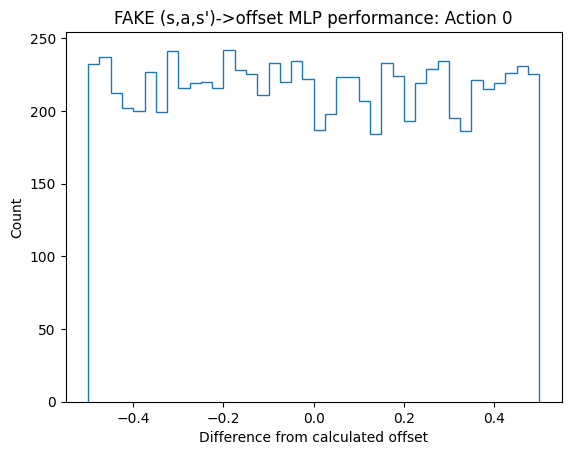

In [115]:
counts, bins = np.histogram(fake_diffs[:,0], bins=40)
plt.stairs(counts, bins)
plt.ylabel('Count')
plt.xlabel('Difference from calculated offset')
plt.title("FAKE (s,a,s')->offset MLP performance: Action 0")
plt.show()

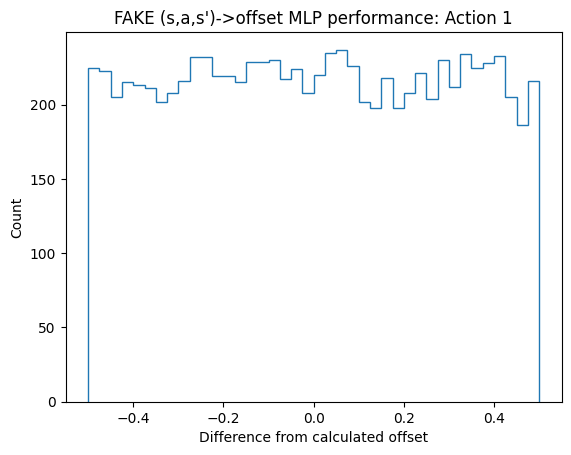

In [116]:
counts, bins = np.histogram(fake_diffs[:,1], bins=40)
plt.stairs(counts, bins)
plt.ylabel('Count')
plt.xlabel('Difference from calculated offset')
plt.title("FAKE (s,a,s')->offset MLP performance: Action 1")
plt.show()